# Deaths in 2021 vs 2019 - Has COVID Really Changed Things? 

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Set Theme for Consistent Look

In [2]:
pal = sns.color_palette("colorblind")
print(pal.as_hex())
pal

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
# I wanted to use colorblind palette, but some colors selected for line charts clash
# So reduce the palette down and just kept specific colours to improve the line charts and keep colorblind-friendliness
colours = ['#0173b2', '#d55e00', '#029e73', '#cc78bc', '#ece133', '#949494', '#ca9161', '#56b4e9']
sns.set_palette(colours)
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
# Using colorblindness-friendly colour scheme
sns.set_theme(style="ticks", palette=colours, font="serif")

## Read Data In

In [5]:
# 2019 data
xls = pd.ExcelFile('deaths2019.xls') # open excel file to access sheets
total_deaths2019 = pd.read_excel(xls, 'deathstotals2019')
age_deaths2019 = pd.read_excel(xls, 'deathsage2019')
xls.close() # close excel file again

# 2021 data
xls2 = pd.ExcelFile('deaths2021.xlsx') # open excel file to access sheets
total_deaths2021 = pd.read_excel(xls2, 'deathstotal2021')
age_deaths2021 = pd.read_excel(xls2, 'deathsage2021')
covid_deaths_place2021 = pd.read_excel(xls2, 'covdeathplace')
covid_deaths_total = pd.read_excel(xls2, 'covdeathplacedec19dec21')
xls2.close() # close excel file again

## Pre-Process Data

#### Deaths by Age Data

In [6]:
# Group the Age Bands together so that 2021 data matches the less granular 2019 data
age_deaths2021["0-14"] = age_deaths2021["<1"] + age_deaths2021["1-4"] + age_deaths2021["5-9"] + age_deaths2021["10-14"]
age_deaths2021["15-44"] = age_deaths2021["15-19"] + age_deaths2021["20-24"] + age_deaths2021["25-29"] + age_deaths2021["30-34"] + age_deaths2021["35-39"] + age_deaths2021["40-44"]
age_deaths2021["45-64"] = age_deaths2021["45-49"] + age_deaths2021["50-54"] + age_deaths2021["55-59"] + age_deaths2021["60-64"] 
age_deaths2021["65-74"] = age_deaths2021["65-69"] + age_deaths2021["70-74"] 
age_deaths2021["75-84"] = age_deaths2021["75-79"] + age_deaths2021["80-84"] 
age_deaths2021["85+"] = age_deaths2021["75-79"] + age_deaths2021["80-84"] + age_deaths2021["85-89"] + age_deaths2021["90+"]
# Add a column for year
age_deaths2021["Year"] = 2021    
# Drop redundant columns
age_deaths2021.drop(['<1', '1-4', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+'], axis=1, inplace=True)
# Re-order the columns
age_deaths2021 = age_deaths2021[["Year", 'Week number', 'Week ended', 'Gender', '0-14', '15-44', '45-64',
       '65-74', '75-84', '85+']]

In [7]:
# Group the <1 and 1-14 Age Bands together for tidier visualisation 
age_deaths2019["0-14"] = age_deaths2019["Under 1 year"] + age_deaths2019["01-14"]
# Add a column for year
age_deaths2019["Year"] = 2019  
# Drop redundant columns
age_deaths2019.drop(["Under 1 year", "01-14"], axis=1, inplace=True)
# Re-order the columns
age_deaths2019 = age_deaths2019[["Year", 'Week number', 'Week ended', 'Gender', '0-14', '15-44', '45-64',
       '65-74', '75-84', '85+']]

In [8]:
# Pivot the table to give Deaths with Age Band labels
age_deaths2019 = age_deaths2019.melt(id_vars = ["Year", "Week number", "Week ended", "Gender"], value_name="Deaths")
age_deaths2021 = age_deaths2021.melt(id_vars = ["Year", "Week number", "Week ended", "Gender"], value_name="Deaths")

In [9]:
# Concatenate the two tables (2019 + 2021) and rename the pivoted label column
age_deaths = pd.concat([age_deaths2019, age_deaths2021], ignore_index=True)
age_deaths.rename(columns={"variable": "Age Band"}, inplace=True)

#### Deaths by Type Data

In [10]:
# Pivot the table to give Deaths with Type label and rename the label column
total_deaths2021 = total_deaths2021.melt(id_vars = ["Week number", "Week ended", "Total deaths", "Total deaths 2020"], value_name="Deaths")
total_deaths2021.rename(columns={"variable": "Type"}, inplace=True)
# Add a column for year
total_deaths2021["Year"] = 2021

In [11]:
# Pivot the table to give Deaths with Type label and rename the label column
total_deaths2019 = total_deaths2019.melt(id_vars = ["Week number", "Week ended", "Total deaths", "Total deaths prev 5yrs"], value_name="Deaths")
total_deaths2019.rename(columns={"variable": "Type"}, inplace=True)
# Add a column for year
total_deaths2019["Year"] = 2019

In [12]:
# Concatenate the two tables (2019 + 2021) 
total_deaths = pd.concat([total_deaths2019, total_deaths2021], ignore_index=True)

#### Deaths by Setting/Place Data

In [13]:
# Rename a column that is unnamed
covid_deaths_total.rename(columns={"Unnamed: 0": "Place"}, inplace=True)
# Tidy up the label for one of the Places as it is too long
covid_deaths_total.replace(["Hospital (acute or community, not psychiatric)"], ["Hospital"], inplace=True)
# Drop the "Total" value
covid_deaths_total.drop([0, 0], inplace=True)
# Create a new column for Non-COVID deaths by subtracting COVID deaths from the Total deaths and sort the dataframe
covid_deaths_total["Non-COVID deaths"] = covid_deaths_total["Total deaths"] - covid_deaths_total["COVID-19 deaths"]
covid_deaths_total.sort_values(by='Total deaths', ignore_index=True, inplace=True)
# Drop the now defunct Total deaths column
covid_deaths_total.drop("Total deaths", axis=1, inplace=True)
# Re-order the columns
covid_deaths_total = covid_deaths_total[["Place", "Non-COVID deaths", "COVID-19 deaths"]]

In [14]:
# Fill the NaN values with the previous value (ie forward fill)
covid_deaths_place2021.fillna(method="ffill", inplace=True)
# Replace COVID-19 with COVID as hyphen causes errors
covid_deaths_place2021.replace(["COVID-19 deaths"], ["COVID deaths"], inplace=True)
# Rename a column that is unnamed
covid_deaths_place2021.rename(columns={"Unnamed: 2": "Type", "Hospital (acute or community, not psychiatric)": "Hospital"}, inplace=True)
covid_deaths_place2021.drop("All deaths", axis=1, inplace=True)

In [15]:
# Force data types to numeric as visualisations were erroring
cols = ['Home', 'Hospital', 'Hospice', 'Care Home', 'Other communal establishment', 'Elsewhere']
covid_deaths_place2021[cols] = covid_deaths_place2021[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [16]:
# Pivot the table to give Deaths with Place label and rename the label column
covid_deaths_place2021 = covid_deaths_place2021.melt(id_vars = ["Week number", "Week ended", "Type"], value_name="Deaths", var_name="Place")

In [17]:
# Filter out the Total deaths 
covid_deaths_place2021 = covid_deaths_place2021[covid_deaths_place2021.reset_index().index % 3 != 0]

## Data Visualisation

Deaths in 2021 vs 2019 - Has COVID Really Changed Things?

Text(0.5, 0.98, 'Deaths By Age Group - 2019 vs 2021 (pre-COVID vs during-COVID pandemic)')

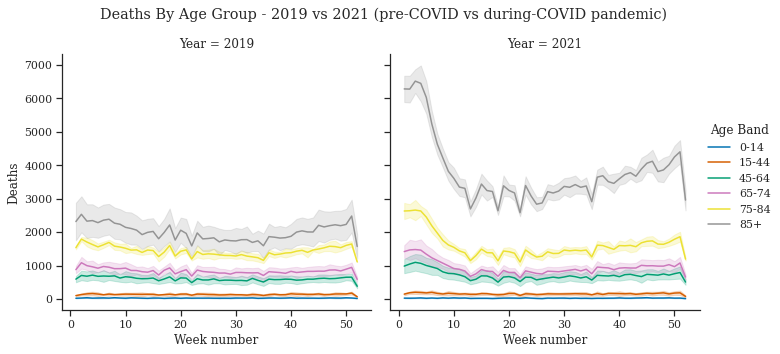

In [18]:
# Create a line plot comparing number of deaths in 2019 and 2021 by Age and Year
g = sns.relplot(data=age_deaths, x="Week number", y="Deaths", hue="Age Band", col="Year", kind="line")
g.fig.subplots_adjust(top=0.85) 
g.fig.suptitle('Deaths By Age Group - 2019 vs 2021 (pre-COVID vs during-COVID pandemic)')

Can this increase in deaths in older age groups be explained by COVID? 

Text(0.5, 0.98, 'Deaths by Type - 2019 vs 2021 (pre-COVID vs during-COVID pandemic)')

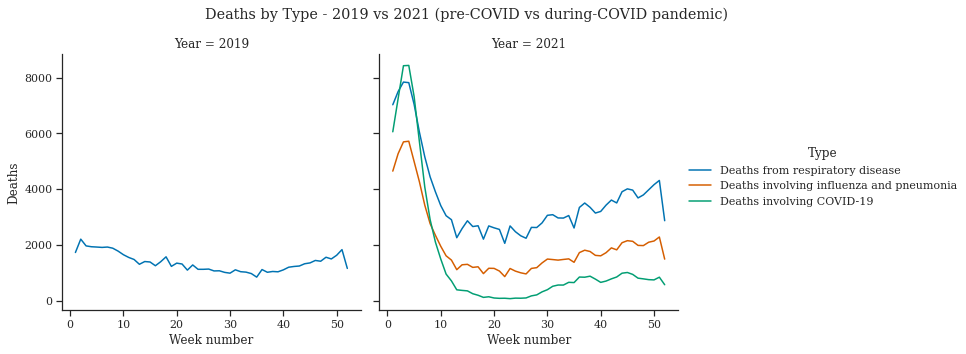

In [19]:
# Create a similar line chart this time for the types of deaths recorded by Year
g = sns.relplot(data=total_deaths, x="Week number", y="Deaths", hue="Type", col="Year", kind="line")
g.fig.subplots_adjust(top=0.85) 
g.fig.suptitle('Deaths by Type - 2019 vs 2021 (pre-COVID vs during-COVID pandemic)')

In what setting do COVID deaths occur?

Text(0.5, 0, 'Number of Deaths')

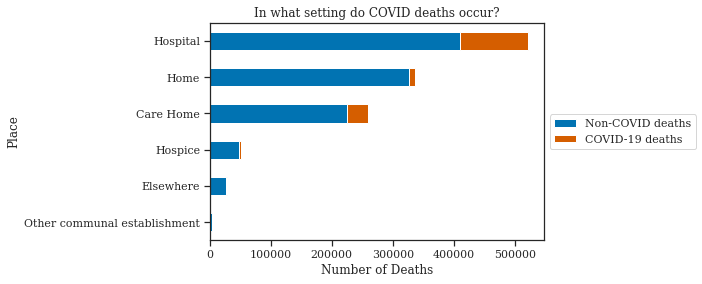

In [20]:
# Create a stacked bar chart showing where Non-COVID and COVID deaths occur (i.e. Hospital, Home, etc)
covid_deaths_total.plot(x='Place', kind='barh', stacked=True, 
        title='In what setting do COVID deaths occur?')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Number of Deaths")

But that just gives us a total view - is there anything in the trend over time to explain COVID deaths?

Text(0.5, 0.98, 'COVID deaths vs Non-COVID deaths - Is there a difference when looking at trend over time?')

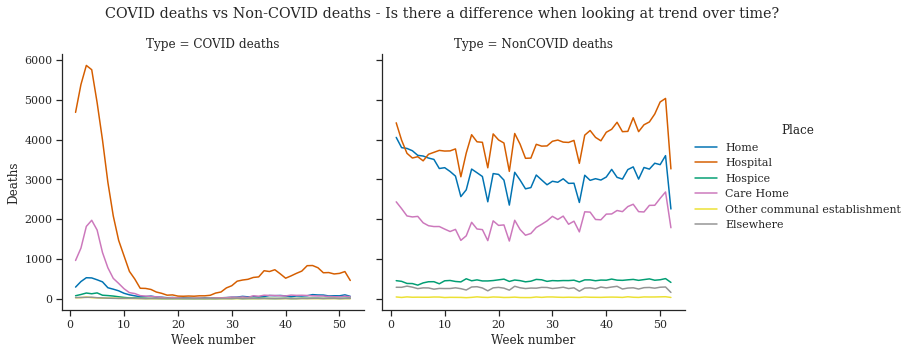

In [21]:
# Look at place of death over time - what does this tell us? 
g = sns.relplot(data=covid_deaths_place2021, x="Week number", y="Deaths", hue="Place", col="Type", kind="line")
g.fig.subplots_adjust(top=0.85) 
g.fig.suptitle('COVID deaths vs Non-COVID deaths - Is there a difference when looking at trend over time?')